In [1]:
using ReinforcementLearningAnIntroduction

Note that the `MountainCar` in the `RLIntro` is a slightly different different from the one in `ReinforcementLearningEnvironments`.

In [2]:
using Plots

using StatsBase

using SparseArrays

In [3]:
env = MountainCar.MountainCarEnv()

MountainCarEnv(-0.45872013821353175, 0.0)

In [4]:
obs_space = get_observation_space(env)

MultiContinuousSpace{Array{Float64,1}}([-1.2, -0.07], [0.5, 0.07])

In [5]:
na = length(get_action_space(env))

3

In [6]:
ntilings = 8
ntiles = 8
tiling = Tiling(Tuple(range(l, step=(h-l)/ntiles, length=ntiles+2) for (l, h) in zip(obs_space.low, obs_space.high)))
offset = (obs_space.high .- obs_space.low) ./ (ntiles * ntilings)
tilings = [tiling - offset .* (i-1) for i in 1:ntilings]

8-element Array{Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}},1}:
 Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}((-1.2:0.2125:0.7125, -0.07:0.0175:0.0875), [1 10 … 64 73; 2 11 … 65 74; … ; 8 17 … 71 80; 9 18 … 72 81])                 
 Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}((-1.2265625:0.2125:0.6859375, -0.0721875:0.0175:0.0853125), [1 10 … 64 73; 2 11 … 65 74; … ; 8 17 … 71 80; 9 18 … 72 81])
 Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}((-1.253125:0.2125:0.659375, -0.074375:0.0175:0.083125), [1 10 … 64 73; 2 11 … 65 74; … ; 8 17 … 71 80; 9 18 … 72 81])    
 Tiling{2,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}((-1.2796875:0.2125:0.6328125, -0.0765625:0.0175:0.0809375), [1 10 … 64 73; 2 11 … 65 74; … ; 8 17 … 71 80; 9 18 … 72 81])
 Tiling{2,StepRangeLen{Float64,Base.Tw

In [7]:
TilingPreprocessor(tilings)(obs_space.low), TilingPreprocessor(tilings)(obs_space.high)

([1, 1, 1, 1, 1, 1, 1, 1], [81, 81, 81, 81, 81, 81, 81, 81])

In [8]:
(POSITION_MIN, VELOCITY_MIN), (POSITION_MAX, VELOCITY_MAX) = obs_space.low, obs_space.high

([-1.2, -0.07], [0.5, 0.07])

By using `TilingPreprocessor`, we transform a state of two scalars (like `[-0.55, 0.0]`) to a vector of Int (like `[39, 40, 40, 40, 40, 40, 40, 40]`). To use the `LinearQApproximator`, we need to encdoe this new state together with an action into a feature vector:

In [9]:
const STATE_INDICES = LinearIndices(
    (
        ntilings,
        (ntiles+1)^2, # the maximum index among the elements of the preprocessed state
        na,
    )
)

8×81×3 LinearIndices{3,Tuple{Base.OneTo{Int64},Base.OneTo{Int64},Base.OneTo{Int64}}}:
[:, :, 1] =
 1   9  17  25  33  41  49  57  65  73  …  593  601  609  617  625  633  641
 2  10  18  26  34  42  50  58  66  74     594  602  610  618  626  634  642
 3  11  19  27  35  43  51  59  67  75     595  603  611  619  627  635  643
 4  12  20  28  36  44  52  60  68  76     596  604  612  620  628  636  644
 5  13  21  29  37  45  53  61  69  77     597  605  613  621  629  637  645
 6  14  22  30  38  46  54  62  70  78  …  598  606  614  622  630  638  646
 7  15  23  31  39  47  55  63  71  79     599  607  615  623  631  639  647
 8  16  24  32  40  48  56  64  72  80     600  608  616  624  632  640  648

[:, :, 2] =
 649  657  665  673  681  689  697  …  1249  1257  1265  1273  1281  1289
 650  658  666  674  682  690  698     1250  1258  1266  1274  1282  1290
 651  659  667  675  683  691  699     1251  1259  1267  1275  1283  1291
 652  660  668  676  684  692  700     1252  1260  

In [10]:
encode_state_action(state::Vector{Int}, action) = sparsevec([STATE_INDICES[i, s, action] for (i, s) in enumerate(state)], ones(length(state)), length(STATE_INDICES))
encode_state_action(obs, action) = encode_state_action(get_state(obs), action)

encode_state_action (generic function with 2 methods)

In [11]:
function create_env_agent(α=2e-4, n=0)
    env = WrappedEnv(
        env=MountainCar.MountainCarEnv(),
        preprocessor=TilingPreprocessor(tilings) 
    )

    agent = Agent(
        policy=QBasedPolicy(
            learner=TDLearner(
                approximator=LinearQApproximator(
                    weights=zeros(length(STATE_INDICES)),
                    feature_func=encode_state_action,
                    actions=collect(1:na)
                    ),
                optimizer=Descent(α),
                n=n
                ),
            explorer=GreedyExplorer()
            ),
        trajectory=EpisodicCompactSARTSATrajectory(;state_type=Vector{Int})
    )

    env, agent
end

create_env_agent (generic function with 3 methods)

In [12]:
function show_approximation(n)
    env, agent = create_env_agent()
    run(agent, env, StopAfterEpisode(n))
    [agent.policy.learner.approximator(env.preprocessor([p, v])) |> maximum
        for p in range(POSITION_MIN, stop=POSITION_MAX, length=40),
            v in range(VELOCITY_MIN, stop=VELOCITY_MAX, length=40)]
end

show_approximation (generic function with 1 method)

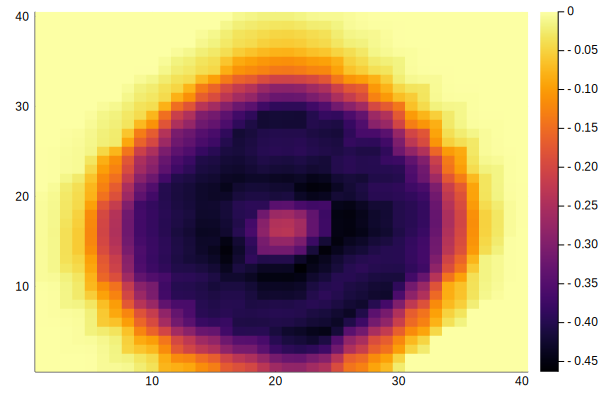

In [13]:
heatmap(show_approximation(1))

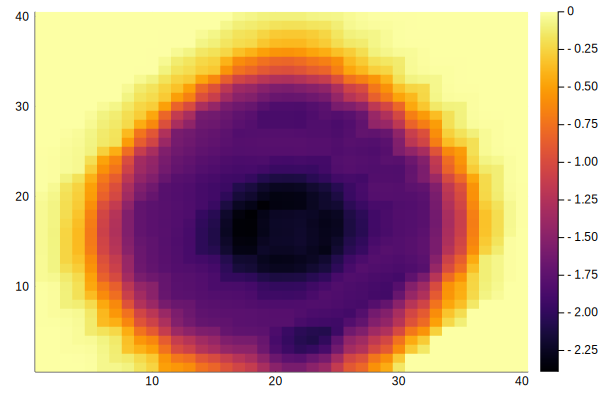

In [14]:
heatmap(show_approximation(12))

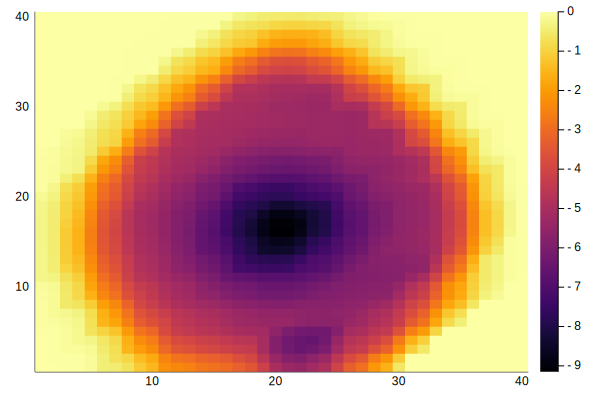

In [15]:
heatmap(show_approximation(104))

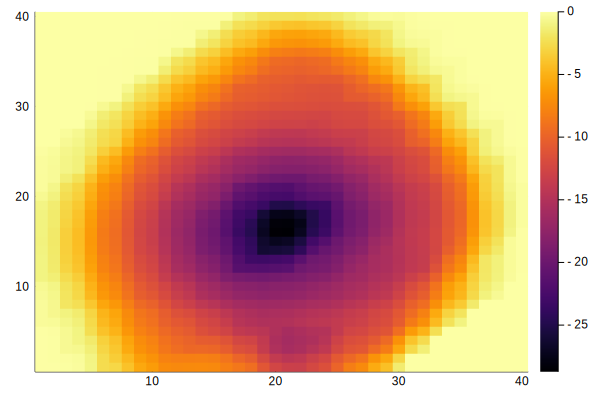

In [16]:
heatmap(show_approximation(1000))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


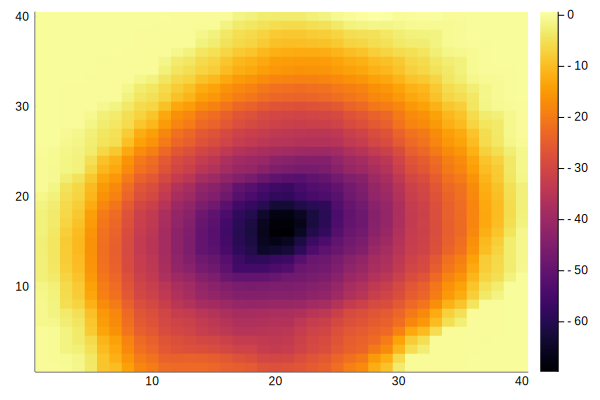

In [17]:
heatmap(show_approximation(9000))

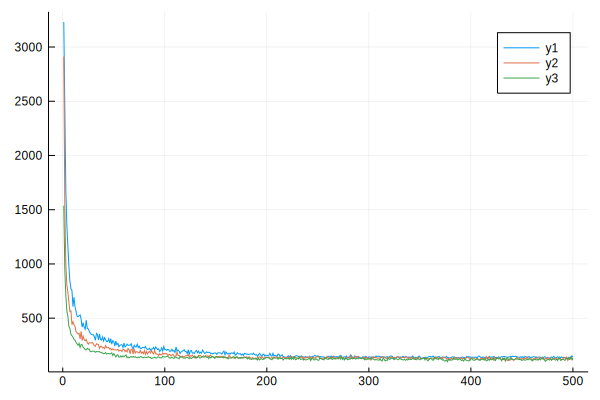

In [18]:
p = plot(legend=:topright)
n_runs = 10  # about 2 seconds per run, quite slow here, need revisit
for α in [0.1/8, 0.2/8, 0.5/8]
    avg_steps_per_episode = zeros(500)
    for _ in 1:n_runs
        env, agent = create_env_agent(α)
        hook = StepsPerEpisode()
        run(agent, env, StopAfterEpisode(500; is_show_progress=false),hook)
        avg_steps_per_episode .+= hook.steps
    end
    plot!(p, avg_steps_per_episode ./ n_runs)
end
p

In [19]:
function run_once(α, n)
    env, agent = create_env_agent(α, n)
    hook = StepsPerEpisode()
    run(agent, env, StopAfterEpisode(50),hook)
    mean(hook.steps)
end

run_once (generic function with 1 method)

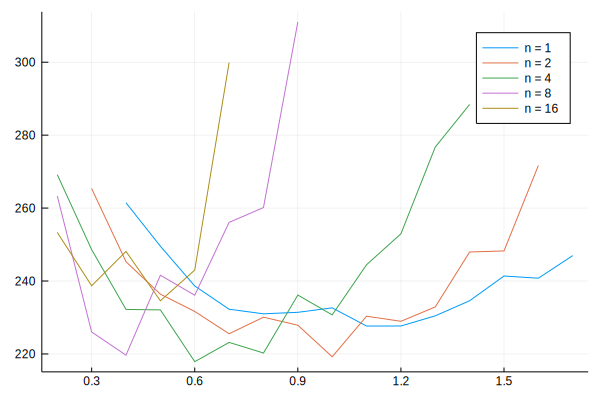

In [20]:
p = plot(legend=:topright)
for (A, n) in [(0.4:0.1:1.7, 1), (0.3:0.1:1.6, 2), (0.2:0.1:1.4, 4), (0.2:0.1:0.9, 8), (0.2:0.1:0.7, 16)]
    plot!(p, A, [mean(run_once(α/8, n) for _ in 1:5) for α in A], label="n = $n")
end
p